### Feature Scaling
- MinMaxScaler
- StandardScaler
- RobustScaler 

metrics           MAE (min)         RMSE (min)         R2 (max)       
state                 as is  scaled      as is  scaled    as is scaled
Linear Regression    44.618  44.754     55.652  55.763    0.393  0.390
Ridge                44.107  44.569     55.015  55.340    0.407  0.400
Lasso                44.618  44.754     55.652  55.568    0.393  0.395

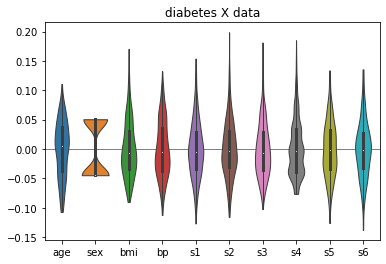

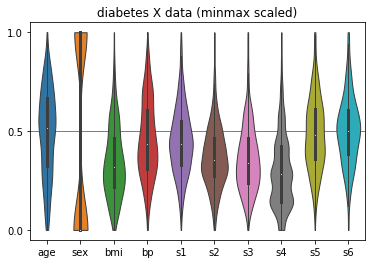

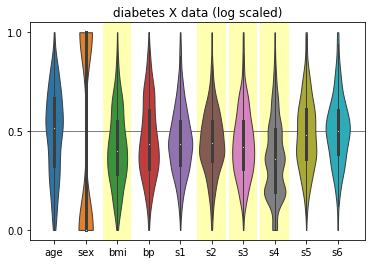

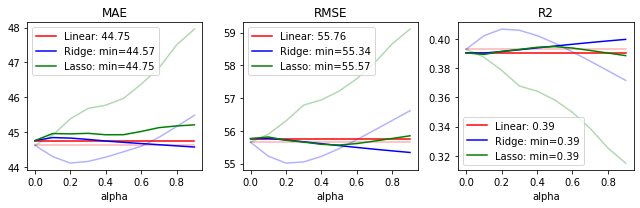

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Scaler 라이브러리 로드
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings(action='ignore')

# 당뇨병 데이터셋 로드
diabetes = load_diabetes()

# 데이터 분포 시각화
X = diabetes["data"]
y = diabetes["target"]
fig, ax = plt.subplots()
sns.violinplot(data=X, cut=0, linewidth=1, ax=ax)
ax.axhline(0, c="gray", lw=1, zorder=0.1)
ax.set_xticklabels(diabetes["feature_names"])
ax.set_title("diabetes X data")

# 평가 지표 계산 함수 정의
def get_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    return mae, rmse, r2

# 주어진 회귀 방법에 따른 평가 지표 계산 함수 정의
def get_metrics_list(X_trn, X_test, y_trn, y_test, regressor, regulation=True):
    maes, rmses, r2s = [], [], []
    alphas = list(np.arange(0, 1, 0.1, dtype="float"))    
    
    for a in alphas:
        if regulation:
            clf = regressor(alpha=a)
        else:
            clf = regressor()
            
        clf.fit(X_trn, y_trn)
        y_pred = clf.predict(X_test)

        mae, rmse, r2 = get_metrics(y_test, y_pred)
        maes.append(mae)
        rmses.append(rmse)
        r2s.append(r2)            
    
    return alphas, maes, rmses, r2s

# 데이터 변환 함수
def get_transformed(data, method):
    
    if method == 'log':
        transformed = np.log1p(data)/np.log1p(1)
    elif method == 'minmax':
        scaler = MinMaxScaler()
        transformed = scaler.fit_transform(data)
    elif method == 'standard':
        scaler = StandardScaler()
        transformed = scaler.fit_transform(data)
    elif method == 'robust':
        scaler = RobustScaler()
        transformed = scaler.fit_transform(data)

    return transformed


# 변환 전 데이터 train-test split
X_trn, X_test, y_trn, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 회귀 모델 학습
alphas, maes_lr, rmses_lr, r2s_lr = get_metrics_list(X_trn, X_test, y_trn, y_test, LinearRegression, regulation=False)
alphas, maes_rg, rmses_rg, r2s_rg = get_metrics_list(X_trn, X_test, y_trn, y_test, Ridge, regulation=True)
alphas, maes_ls, rmses_ls, r2s_ls = get_metrics_list(X_trn, X_test, y_trn, y_test, Lasso, regulation=True)

# 데이터 변환 후 시각화
X_transformed = get_transformed(X, "minmax")
fig, ax = plt.subplots()
v = sns.violinplot(data=X_transformed, cut=0, linewidth=1, ax=ax)
ax.set_title("diabetes X data (minmax scaled)")
ax.set_xticklabels(diabetes["feature_names"])
ax.set_yticks([0, 0.5, 1])
ax.axhline(0.5, c="gray", lw=1, zorder=0.1)
fig.savefig('./data/X_transformed.png')

for idx in [2, 5, 6, 7]:
    transformed = get_transformed(X_transformed[:, idx].reshape(-1, 1), "log")
    X_transformed[:, idx] = transformed.flatten()
fig, ax = plt.subplots()
sns.violinplot(data=X_transformed, cut=0, linewidth=1, ax=ax)
ax.axhline(0.5, c="gray", lw=1, zorder=0.1)
ylim = ax.get_ylim()

for idx in [2, 5, 6, 7]:
    ax.axvspan(idx-0.45, idx+0.45, ylim[0], ylim[1], fc="yellow", zorder=0.1, alpha=0.3)
ax.set_xticklabels(diabetes["feature_names"])
ax.set_yticks([0, 0.5, 1])
ax.set_title("diabetes X data (log scaled)")
fig.savefig('./data/diabetes X data (log scaled).png')

# 변환된 데이터 train-test split
X_trn, X_test, y_trn, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=0)

# 학습 결과 계산
alphas, maes_lr_scale, rmses_lr_scale, r2s_lr_scale = get_metrics_list(X_trn, X_test, y_trn, y_test, LinearRegression, regulation=False)
alphas, maes_rg_scale, rmses_rg_scale, r2s_rg_scale = get_metrics_list(X_trn, X_test, y_trn, y_test, Ridge, regulation=True)
alphas, maes_ls_scale, rmses_ls_scale, r2s_ls_scale = get_metrics_list(X_trn, X_test, y_trn, y_test, Lasso, regulation=True)

# 결과 시각화
fig, axs = plt.subplots(ncols=3, figsize=(9, 3))

def plot_metric(alphas, metric1, metric2, metric3, metric1_scale, metric2_scale, metric3_scale, title, ax):
    ax.plot(alphas, metric1, c="r", alpha=0.3)
    ax.plot(alphas, metric2, c="b", alpha=0.3)
    ax.plot(alphas, metric3, c="g", alpha=0.3)
    ax.plot(alphas, metric1_scale, c="r", label=f"Linear: {metric1_scale[0]:0.2f}")
    ax.plot(alphas, metric2_scale, c="b", label=f"Ridge: min={min(metric2_scale):0.2f}")
    ax.plot(alphas, metric3_scale, c="g", label=f"Lasso: min={min(metric3_scale):0.2f}")
    ax.set_title(title)
    ax.set_xlabel("alpha")
    ax.legend()    
    return ax

axs[0] = plot_metric(alphas, maes_lr, maes_rg, maes_ls, maes_lr_scale, maes_rg_scale, maes_ls_scale, "MAE", axs[0])    
axs[1] = plot_metric(alphas, rmses_lr, rmses_rg, rmses_ls, rmses_lr_scale, rmses_rg_scale, rmses_ls_scale, "RMSE", axs[1])
axs[2] = plot_metric(alphas, r2s_lr, r2s_rg, r2s_ls, r2s_lr_scale, r2s_rg_scale, r2s_ls_scale, "R2", axs[2])

fig.tight_layout()

iterables = [["MAE (min)", "RMSE (min)", "R2 (max)"], ["as is", "scaled"]]
columns = pd.MultiIndex.from_product(iterables, names=["metrics", "state"])
data = [[min(maes_lr), min(maes_lr_scale), min(rmses_lr), min(rmses_lr_scale), max(r2s_lr), max(r2s_lr_scale)],
        [min(maes_rg), min(maes_rg_scale), min(rmses_rg), min(rmses_rg_scale), max(r2s_rg), max(r2s_rg_scale)],
        [min(maes_ls), min(maes_ls_scale), min(rmses_ls), min(rmses_ls_scale), max(r2s_ls), max(r2s_ls_scale)]]
df_summary = pd.DataFrame(index = ["Linear Regression", "Ridge", "Lasso"],
                          columns = columns,
                          data = data).applymap(lambda x: f"{x:0.3f}")
display(df_summary)

### best alpha에 대한 선형 모델 계수 추출

,LinearRegression,Ridge,Lasso
age,-14.747256,-11.873146,-0.000000
sex,-18.967234,-18.898930,-14.376036
bmi,141.749073,134.428508,137.301006
bp,67.424002,66.926715,53.611534
s1,-144.413836,-27.044025,-16.685375
s2,68.654972,-25.102339,-0.000000
s3,-11.521999,-57.359376,-61.016588
s4,29.902434,23.891562,0.000000
s5,186.290238,131.260430,136.295038
s6,8.681987,14.141867,0.000000


(-202.82544133596627, 202.82544133596627)

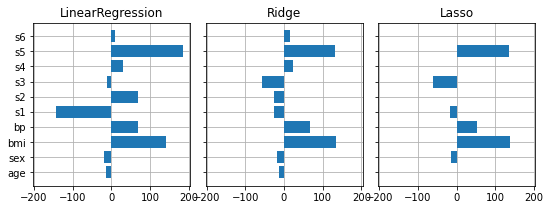

In [2]:
# Ridge, Lasso에서 alpha 추출
alpha_rg_best = alphas[np.argmax(r2s_rg_scale)]
alpha_ls_best = alphas[np.argmax(r2s_ls_scale)]

# 주어진 regressor의 계수 출력
def get_coef(X_trn, y_trn, regressor, alpha=None):
    if alpha == None:
        reg = regressor()
    else:
        reg = regressor(alpha=alpha)
    reg.fit(X_trn, y_trn)
    y_pred = reg.predict(X_test)
    return pd.DataFrame(data = reg.coef_, 
                        columns = [str(regressor).split("'")[-2].split(".")[-1]],
                        index = diabetes["feature_names"])

# 결과 출력을 위한 DataFrame 생성
models = [LinearRegression, Ridge, Lasso]
alphas_best = [None, alpha_rg_best, alpha_ls_best]

df_coef = pd.DataFrame()
for model, alpha in zip(models, alphas_best):
    df_coef_ = get_coef(X_trn, y_trn, model, alpha)
    df_coef = pd.concat([df_coef, df_coef_], axis=1)

# 결과 시각화
display(df_coef)
fig, axs = plt.subplots(ncols=3, figsize=(9, 3), 
                        sharex=True, sharey=True,
                        gridspec_kw={'wspace':0.1})
for ax, col in zip(axs, df_coef.columns):
    ax.barh(df_coef.index, df_coef[col], zorder=2)
    ax.grid()
    ax.set_title(col)
xlim = max([abs(x) for x in axs[0].get_xlim()])
axs[0].set_xlim(-xlim, xlim)